# SPAM OR NOT SPAM?

# 1. INTRODUCTION

We receive a large number of emails every day, therefore a tool capable of classifying them in spam or not, becomes very important in order to not waste our time.

**In this project we will use machine learning and text mining to predict if a message is spam or not**, based on some features of the message, as for example:

* The characters that appear on it.
* The length of the message.
* The number of digits.
* The number of non-word characters (anything other than a letter, digit or underscore).

# 2. CLEANING THE DATA

In this section, we are going to get the data and cleaning it for further manipulation.

We get all the messages from a .csv file and we store them in a data frame (**spam_data**) with the columns *text* and *target*, where *target = 1* if the message is spam or *target = 0* if not.

In [1]:
import pandas as pd
import numpy as np

spam_data = pd.read_csv('spam.csv')
spam_data['target'] = np.where(spam_data['target'] == 'spam', 1, 0)
spam_data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


How many messages are in the .csv file?

In [2]:
print('There are {} messages in the file.'.format(len(spam_data)))

There are 5572 messages in the file.


How many messages from the .csv file are spam?

In [3]:
print('The {:.2f}% of the messages are spam.'.format(spam_data.target.sum() / len(spam_data) * 100))

The 13.41% of the messages are spam.


# 3. COMPUTING FEATURES

In this section, we are going to compute features from the messages that we are going to use to train and test the models. We are going to check also if we get different values of these features for messages that are spam from those that are not, this will tell us if they are good at predicting the target value.

Length of each message:

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

spam_data['length'] = spam_data.text.str.len()

print('The mean length of the messages that are spam is {:.2f} whereas of the messages that are not spam is {:.2f}.'
     .format(spam_data[spam_data.target == 1].length.mean(), spam_data[spam_data.target == 0].length.mean() ))

The mean length of the messages that are spam is 138.87 whereas of the messages that are not spam is 71.02.


The number of digits in each message:

In [5]:
spam_data['digits'] = spam_data.text.str.count(r'\d')

print('The mean number of digits of the messages that are spam is {:.2f} whereas of the messages that are not spam is {:.2f}.'
     .format(spam_data[spam_data.target == 1].digits.mean(), spam_data[spam_data.target == 0].digits.mean() ))

The mean number of digits of the messages that are spam is 15.76 whereas of the messages that are not spam is 0.30.


The number of non-word characters in each message:

In [6]:
spam_data['non-word'] = spam_data.text.str.count(r'\W') 

print('The mean number of non-word characters of the messages that are spam is {:.2f} whereas of the messages that are not spam is {:.2f}.'
     .format(spam_data[spam_data.target == 1]['non-word'].mean(), spam_data[spam_data.target == 0]['non-word'].mean() )) 

The mean number of non-word characters of the messages that are spam is 29.04 whereas of the messages that are not spam is 17.29.


In [7]:
spam_data.head()

,text,target,length,digits,non-word
0,"Go until jurong point, crazy.. Available only ...",0,111,0,28
1,Ok lar... Joking wif u oni...,0,29,0,11
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,25,33
3,U dun say so early hor... U c already then say...,0,49,0,16
4,"Nah I don't think he goes to usf, he lives aro...",0,61,0,14


We can see how **the values obtained for messages that are spam are significantly different from those that are not**, so they are good features to predict the target value.

Next, we are going to **build a vocabulary** with the tokens that appear in all the messages from *spam_data* and transform these messages in a matrix that provide us with a *'bag-of-words'* stored in X, where **each row corresponds to a message and each column corresponds to a token in our vocabulary**, so of this way we know which tokens appear in each message.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df = 5, ngram_range = (2,5), analyzer = 'char_wb').fit(spam_data['text']) # vocabulary
X = vect.transform(spam_data['text']) # bag-of-words
print('We have {} tokens in our vocabulary.'.format(len(vect.get_feature_names())))

We have 19776 tokens in our vocabulary.


We join the *bag-of-words* with the others features (length, digits, non-word) we have computed before:

In [9]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

X = add_feature(X, [spam_data['length'],spam_data['digits'],spam_data['non-word']]) # features
y = spam_data['target'] # target values

# 4. TRAINING AND TESTING 

In this section, we are going to train and test different estimators to see which have a better performance. We will tune the parameters with a **GridSearchCV** and test the classifiers with the **ROC_AUC** score that can be interpreted as the probability that the classifier will assign a higher score to a randomly chosen positive example than to a randomly chosen negative example.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn import svm

scores = []

logreg = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
param_grid = dict(C = [0.1, 1, 10, 100])
grid_1 = GridSearchCV(logreg, param_grid, cv = 10, scoring = 'roc_auc')
grid_1.fit(X, y)
scores.append(grid_1.best_score_)
print('Logistic Regressión score: {}'.format(grid_1.best_score_))
print(grid_1.best_params_)


nb = naive_bayes.MultinomialNB()
param_grid = dict(alpha = [0.1, 1, 10, 100])
grid_2 = GridSearchCV(nb, param_grid, cv = 10, scoring = 'roc_auc')
grid_2.fit(X, y)
scores.append(grid_2.best_score_)
print('Naive Bayes score: {}'.format(grid_2.best_score_))
print(grid_2.best_params_)

svc = svm.SVC(kernel = 'linear')
param_grid = dict(C = [0.1, 1, 10, 100])
grid_3 = GridSearchCV(svc, param_grid, cv = 10, scoring = 'roc_auc')
grid_3.fit(X, y)
scores.append(grid_3.best_score_)
print('Linear_SVC score: {}'.format(grid_3.best_score_))
print(grid_3.best_params_)

Logistic Regressión score: 0.9936617706288813
{'C': 0.1}
Naive Bayes score: 0.9845817422543677
{'alpha': 0.1}
Linear_SVC score: 0.9909993189941502
{'C': 0.1}


Additionally, we are going to compute the execution time for each estimator. We do 10 simulations for each estimator to get the mean of all of them:

In [11]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

grids = [grid_1, grid_2, grid_3]
times = []
for estimator in grids:
    est_t = []
    for attempt in range(10): # we do 10 simulations for each estimator
        start = time.time()
        prediction = estimator.predict(X_test)
        end = time.time()
        est_t.append(end-start)
    times.append(np.asarray(est_t).mean())

In order to see graphically the performance of each classifier, we will do a scatter plot. In the x-axis we have the score and in the y-axis the execution time:

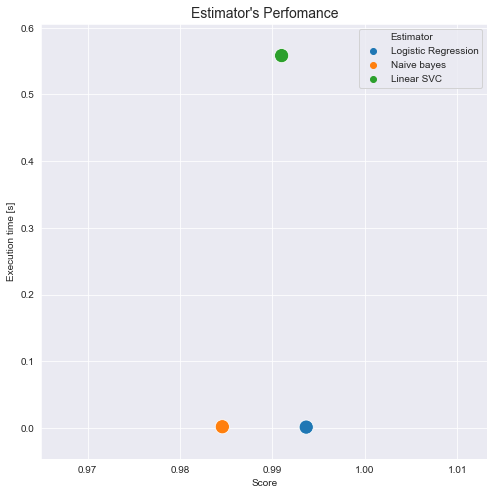

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

l_estim = ['Logistic Regression','Naive bayes', 'Linear SVC']
df_est = pd.DataFrame({'Estimator': l_estim, 'Score': scores, 'Execution time [s]': times})

sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
g = sns.scatterplot(data = df_est, y = 'Execution time [s]', x = 'Score', s = 200, hue = 'Estimator')
plt.title("Estimator's Perfomance", fontsize = 14)
plt.show()

# 5. CONCLUSIONS

We see how the score from the Logistic Regression and the Linear SVC it's close to 1 in both cases but for the Logistic Regression is a bit higher and the execution time is faster, so **we choose the Logistic Regression as the best model with the following parameters**:

In [13]:
print('Best parameters: {}'.format(grid_1.best_params_))

Best parameters: {'C': 0.1}


We have been able to predict if a message is spam with a very high success rate:

In [16]:
logreg = LogisticRegression(C = 0.1, solver = 'lbfgs', max_iter = 1000).fit(X_train, y_train)
print('The succes rate is {:.2f}%'.format(logreg.score(X_test, y_test)*100))

The succes rate is 99.07%
